In [1]:
import os
import pandas as pd
from estnltk import Text
from estnltk.taggers import NerTagger
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from itertools import chain
import pickle
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_fscore_support,accuracy_score, auc, average_precision_score, confusion_matrix, roc_curve, precision_recall_curve

/home/kaire/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
nertagger = NerTagger()

In [3]:
data = pd.read_csv("obl_1000_benchmark.csv", sep=";", encoding="utf-8")
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,la,removetype,short_sent_untoken,sentence_analysis_data,peasona,verb,label
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,82.4,yes,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel, kus just perearste arvestades on põhjust osaleda ka Haigekassal.","('peale', 13, 16, 'osaleda', 17)",peale,osaleda,1
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,33.3,yes,"Kuna eestlased hindavad oma kodu kõrgelt, siis on nende 5-10% kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga, mis ei luba teenitud ettevõtlustulu veel investeerida.","('elamispinda', 28, 30, 'investeerida', 30)",elamispinda,investeerida,1
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,96.7,yes,"Järgnevalt anti kiiresti mitu käsku, lootuses, et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel, kuid Stanfordi antenn ei avastanud midagi.","('Marsile', 2, 2, 'anti', 2)",Marsile,anti,1
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,100.0,yes,"Enne minekut hoiatab ta oma leebel moel, et äri ei tohiks küll ülimaks eesmärgiks saada.","('haiglas', 12, 17, 'saada', 17)",haiglas,saada,1
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,100.0,yes,Peeter kargas läbi akna kuue järele.,"('aeda', 4, 2, 'kargas', 2)",aeda,kargas,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,100.0,no,Tuul loobib pilve teise.,"('kohast', 4, 2, 'loobib', 2)",kohast,loobib,0
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,100.0,no,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima.","('aastal', 9, 9, 'kommenteerima', 9)",aastal,kommenteerima,0
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel oue 57 % paki hinnast .",NaN,NaN,NaN,no,"Tõusevad praktilis

In [4]:
def get_ner_timexes(sentence, phrase):
    text = Text(sentence)
    text = text.tag_layer('morph_analysis')
    nertagger.tag(text)
    text.tag_layer('timexes')
    
    timexes = set(text["timexes"].text)
    ners = set([named_entity.enclosing_text for named_entity in text["ner"] if named_entity.nertag=="LOC"])
    
    phrase_is_ner = False
    phrase_is_timex = False
    
    if phrase in timexes or any(phrase in s for s in timexes):
        phrase_is_timex = True
    if phrase in ners or any(phrase in s for s in ners):
        phrase_is_ner = True
        
    
    return ners, timexes, phrase_is_ner, phrase_is_timex

In [5]:
ner_data = []
timex_data = []
is_ner_data = []
is_timex_data = []

for i in tqdm(range(len(data))):
    sent = data.iloc[i]["sentence"]
    phrase = data.iloc[i]["removed"]    
    
    ner, timex, is_ner, is_timex = get_ner_timexes(sent, phrase)
    
    ner_data.append(ner)
    timex_data.append(timex)
    is_ner_data.append(is_ner)
    is_timex_data.append(is_timex)

100%|███████████████████████████████████████| 1000/1000 [00:50<00:00, 19.93it/s]


In [6]:
data["found_ners"] = ner_data
data["found_timexes"] = timex_data
data["phrase_is_ner"] = is_ner_data
data["phrase_is_timex"] = is_timex_data
data["can_be_removed"] = "no"
data["remove_label"] = 0

In [7]:
data.loc[data.phrase_is_ner == True, 'can_be_removed'] = "yes"
data.loc[data.phrase_is_timex == True, 'can_be_removed'] = "yes"

In [8]:
data.loc[data.phrase_is_ner == True, 'remove_label'] = 1
data.loc[data.phrase_is_timex == True, 'remove_label'] = 1

In [9]:
data

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,...,sentence_analysis_data,peasona,verb,label,found_ners,found_timexes,phrase_is_ner,phrase_is_timex,can_be_removed,remove_label
0,1051,Train/tea_eesti_arst_2004_osa_3_ud211.conllu,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust peale haiglate liidu osaleda ka Haigekassal .",107,127,peale haiglate liidu,free,"Seda ka kohe-kohe algavatel järjekordsetel palgaläbirääkimistel , kus just perearste arvestades on põhjust osaleda ka Haigekassal .",58.8,64.7,...,"('peale', 13, 16, 'osaleda', 17)",peale,osaleda,1,{},{},False,False,no,0
1,1389,Train/aja_luup200106_osa_2_ud211.conllu,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel elamispinda investeerida .",204,215,elamispinda,free,"Kuna eestlased hindavad oma kodu kõrgelt , siis on nende 5-10 % kinnisvaramiljonäride näol tegemist enamasti mingi ooteperioodiga või ettevõtluse algstaadiumiga , mis ei luba teenitud ettevõtlustulu veel investeerida .",20.0,23.3,...,"('elamispinda', 28, 30, 'investeerida', 30)",elamispinda,investeerida,1,{},{},False,False,no,0
2,1109,Train/aja_pm20000218_osa_5_ud211.conllu,"Järgnevalt anti Marsile kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",16,23,Marsile,free,"Järgnevalt anti kiiresti mitu käsku , lootuses , et kosmosesõiduk - kui see oli signaali allikas - annaks signaale edasi samal lainepikkusel , kuid Stanfordi antenn ei avastanud midagi .",86.7,86.7,...,"('Marsile', 2, 2, 'anti', 2)",Marsile,anti,1,"{Stanfordi, Marsile}",{},True,False,yes,1
3,398,Train/aja_luup200202_osa_1_ud211.conllu,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks haiglas küll ülimaks eesmärgiks saada .",59,66,haiglas,free,"Enne minekut hoiatab ta oma leebel moel , et äri ei tohiks küll ülimaks eesmärgiks saada .",100.0,100.0,...,"('haiglas', 12, 17, 'saada', 17)",haiglas,saada,1,{},{},False,False,no,0
4,2346,Train/arborest_ud211.conllu,Peeter kargas läbi akna aeda kuue järele .,24,28,aeda,free,Peeter kargas läbi akna kuue järele .,100.0,100.0,...,"('aeda', 4, 2, 'kargas', 2)",aeda,kargas,1,{},{},False,False,no,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1961,Train/arborest_ud211.conllu,Tuul loobib pilve ühest kohast teise .,18,30,ühest kohast,bound,Tuul loobib pilve teise .,100.0,100.0,...,"('kohast', 4, 2, 'loobib', 2)",kohast,loobib,0,{},{},False,False,no,0
996,1831,Train/aja_sloleht20071217_ud211.conllu,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima aastal 1985 .",65,76,aastal 1985,bound,""" Esimest korda julgeti mind kutsuda mingit teemat kommenteerima .",100.0,100.0,...,"('aastal', 9, 9, 'kommenteerima', 9)",aastal,kommenteerima,0,{},{aastal 1985 .},False,True,yes,1
997,97,Train/aja_luup200106_osa_2_ud211.conllu,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel on miinimumnõue 57 % paki hinnast .",116,128,sigarettidel,bound,"Tõusevad praktiliselt kõik hinnad , suhkur mitu korda , kütus aktsiisi võrra - paar krooni liitrilt , sigarettidel oue 57 % paki hinnast .",NaN,NaN,...,"('sigarettidel', 17, 22, 'Tõusevad', 1)",sigarettidel,Tõusevad,0,{},{},False,False,no,0
998,636,Train/aja_ee200110_osa_8_ud211.conllu,""" Iga koosolek hakkas jälle sõjaga peale , et midagi sellist ei tehtaks , "" meenutab Rannamäe .",46,52,midagi,bound,""" Iga koosolek hakkas jälle sõjaga peale , et sellist ei tehtaks , "" meenutab Rannamäe .",100.0,100.0,...,"('midagi', 9, 11, 'tehtaks', 13)",midagi,tehtaks,0,{},{},False,False,no,0


In [13]:
data[data["remove_label"].isna()]

,id,fpath,sentence,remove_start,remove_end,removed,type,short_sent,cons_score,ual,...,sentence_analysis_data,peasona,verb,label,found_ners,found_timexes,phrase_is_ner,phrase_is_timex,can_be_removed,remove_label


In [14]:
predicted = list(data['remove_label'])
y_test = list(data['label'])

precision, recall, fscore, support = score(y_test, predicted)

print('precision: {}'.format(precision.round(3)))
print('recall: {}'.format(recall.round(3)))
print('fscore: {}'.format(fscore.round(3)))
print('support: {}'.format(support.round(3)))

try:
    precision = precision_score(y_test, predicted, pos_label=1, average='binary')
    recall = recall_score(y_test, predicted, pos_label=1, average='binary')
except:
    precision = precision_score(y_test, predicted, labels=[1], average='micro')
    recall = recall_score(y_test, predicted, labels=[1], average='micro')
print('precision: ',precision.round(3))
print('recall: ',recall.round(3))

precision: [0.513 0.607]
recall: [0.916 0.13 ]
fscore: [0.658 0.214]
support: [500 500]
precision:  0.607
recall:  0.13


In [21]:
data["match"] = data.remove_label.eq(data.label) # true if annotation and prediction are the same

In [22]:
data.value_counts("match")

match
True     523
False    477
Name: count, dtype: int64

In [23]:
data.value_counts("remove_label")

remove_label
0    893
1    107
Name: count, dtype: int64

In [15]:
# Compute global precision and recall
precision1, recall1, thresh1 = precision_recall_curve(y_test, predicted, pos_label=1)

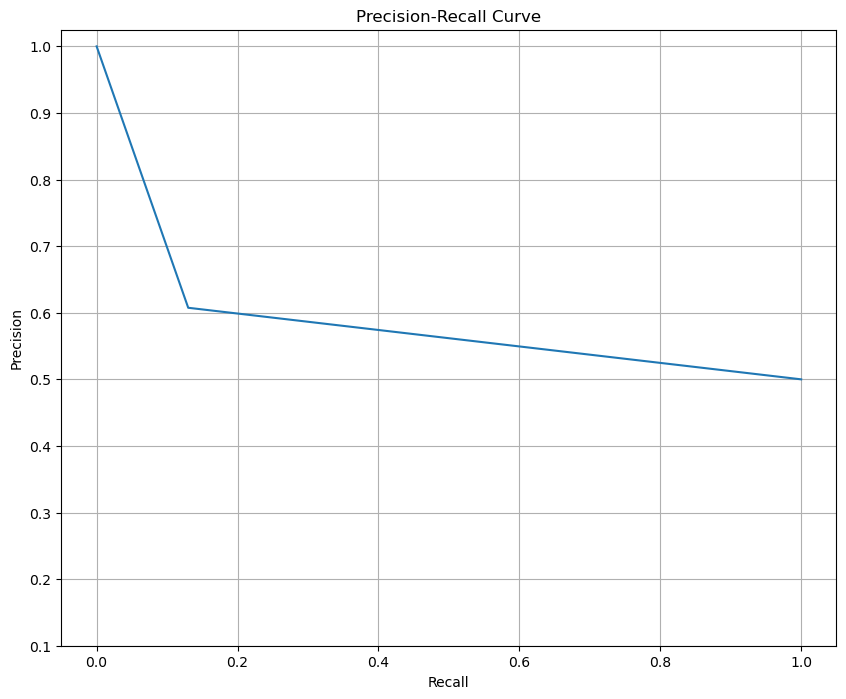

In [16]:
# Plot the precision-recall curve
plt.figure(figsize=(10, 8))
plt.plot(recall1, precision1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.yticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
plt.grid(True)
plt.show()

In [17]:
fpr, tpr, thresholds = roc_curve(y_test, predicted, pos_label=1)

In [18]:
roc_auc = auc(fpr, tpr)

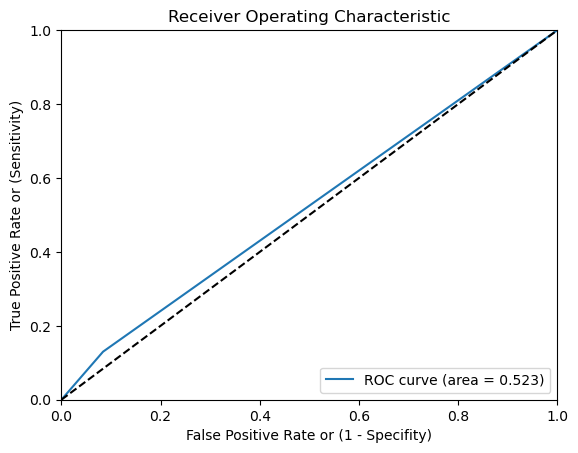

In [19]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

In [24]:
#data.to_csv("obl_gpt_large1_ner_timex_nertagger_benchmark.csv", index=False, sep=";", encoding="utf-8")